In [271]:
import warnings
warnings.filterwarnings("ignore")
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import gensim

from math import exp
from numpy import sign
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
from gensim import models
from nltk.corpus import stopwords
from nltk import PorterStemmer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [272]:
np.random.seed(1)
DEPRES_NROWS = 3200  
RANDOM_NROWS = 1100000
MAX_SEQUENCE_LENGTH = 140 
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.2
LEARNING_RATE = 0.0001
EPOCHS= 5

In [273]:
RANDOM_TWEETS_CSV = 'lastdata.csv'
EMBEDDING_FILE = 'bn.bin'

In [274]:
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV)


In [275]:
random_tweets_df.head()

,message,label
0,যে দেশে মানুষের মৃত্যুর খবর শুনে মন্ত্রী মহোদয...,1
1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,0
2,নিকোটিনের ধোয়ায় সময় কাটে রাতে । রাতটা আমার ...,1
3,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,0
4,কোন সিটিতেই কোন ভোট হিসেব হয়নি যা হচ্ছে হাসিন...,1


In [276]:
word2vec = Word2Vec.load(EMBEDDING_FILE)

In [277]:
random_tweets_arr = [x for x in random_tweets_df['message']]
X_r = random_tweets_arr

In [278]:
X_r = str(X_r).lower()
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_r)
sequences_r = tokenizer.texts_to_sequences(X_r)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_r tensor:', data_r.shape)

Found 73 unique tokens
Shape of data_r tensor: (725670, 140)


In [279]:
EMBEDDING_DIM=300

word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i>=MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word2vec)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)

In [266]:


trainIndex, testIndex = list(), list()
for i in range(random_tweets_df.shape[0]):
    if np.random.uniform(0, 1) < 0.60:
        trainIndex += [i]
        
    else:
        testIndex += [i]
       
    trainData = random_tweets_df.iloc[trainIndex]
testData = random_tweets_df.iloc[testIndex]



labels_r = np.array([0] * RANDOM_NROWS)

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[trainIndex]
idx_test_r = perm_r[testIndex]



data_train = data_r[idx_train_r]
labels_train =  labels_r[idx_train_r]
data_test =  data_r[idx_test_r]
labels_test =  labels_r[idx_test_r]



perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]


In [267]:
model = Sequential()

model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(LSTM(128))
#model.add(Bidirectional(LSTM(512)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [268]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 140, 300)          22200     
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 70, 32)            0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 70, 32)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               82432     
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)               

In [269]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train,\
             validation_data=(data_test, labels_test),  
        epochs=EPOCHS, batch_size= 10, shuffle=True, \
        callbacks=[])

Train on 3494 samples, validate on 2386 samples
Epoch 1/5
3494/3494 [==============================] - 26s 7ms/step - loss: 0.0000e+00 - acc: 0.3872 - val_loss: 0.0000e+00 - val_acc: 0.2724
Epoch 2/5
3494/3494 [==============================] - 26s 8ms/step - loss: 0.0000e+00 - acc: 0.3950 - val_loss: 0.0000e+00 - val_acc: 0.2724
Epoch 3/5
3494/3494 [==============================] - 28s 8ms/step - loss: 0.0000e+00 - acc: 0.3852 - val_loss: 0.0000e+00 - val_acc: 0.2724
Epoch 4/5
3494/3494 [==============================] - 30s 9ms/step - loss: 0.0000e+00 - acc: 0.3864 - val_loss: 0.0000e+00 - val_acc: 0.2724
Epoch 5/5
3494/3494 [==============================] - 29s 8ms/step - loss: 0.0000e+00 - acc: 0.3812 - val_loss: 0.0000e+00 - val_acc: 0.2724


In [270]:
labels_pred = model.predict(data_test)

labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 27.24%


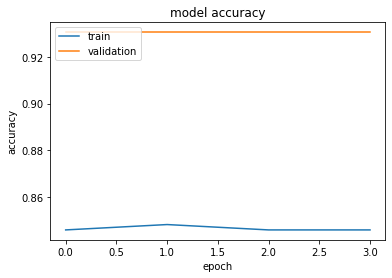

In [256]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

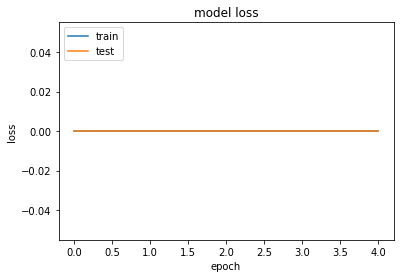

In [20]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.24      0.39      2396
         1.0       0.00      0.00      0.00         0

    accuracy                           0.24      2396
   macro avg       0.50      0.12      0.20      2396
weighted avg       1.00      0.24      0.39      2396



In [22]:
loss, acc = model.evaluate([data_test],labels_test, verbose=0)
print('Test accuracy: %f' % (acc*100))

Test accuracy: 24.415693


In [23]:
import csv

stop_words = 'stopwords_bn.txt'
text_data = []

with open(stop_words, 'r', encoding='utf-8') as temp_output_file:
    reader = csv.reader(temp_output_file, delimiter='\n')
    for row in reader:
        text_data.append(row)

stop_word_list = [x[0] for x in text_data]

In [24]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stop_word_list()
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [25]:
sc_tf_idf = TweetClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['message'])


In [26]:
pm = process_message('অনেক ভাল লাগছেি')
sc_tf_idf.classify(pm)

True